In [25]:
import polars as pl
import numpy as np

# 读取数据
data = pl.read_parquet("hourly_data.pa")

df = data.sort('open_time').sort('symbol')

N = 50

df

open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,symbol
datetime[μs],f64,f64,f64,f64,f64,datetime[μs],f64,i64,f64,f64,str
2022-09-09 13:00:00,0.4728,0.4874,0.3663,0.451,6.5705837e7,2022-09-09 13:59:59.999,2.8487e7,124200,3.3701922e7,1.4632e7,"""1000LUNCUSDT"""
2022-09-09 14:00:00,0.451,0.4609,0.4277,0.4592,4.1316126e7,2022-09-09 14:59:59.999,1.8355e7,94104,2.0298138e7,9.0220e6,"""1000LUNCUSDT"""
2022-09-09 15:00:00,0.4594,0.4734,0.4416,0.4555,4.4134479e7,2022-09-09 15:59:59.999,2.0198e7,103417,2.2353913e7,1.0239e7,"""1000LUNCUSDT"""
2022-09-09 16:00:00,0.4554,0.458,0.4175,0.4297,4.6242265e7,2022-09-09 16:59:59.999,2.0187e7,84951,2.1467246e7,9.3760e6,"""1000LUNCUSDT"""
2022-09-09 17:00:00,0.4297,0.4418,0.4071,0.4156,2.661109e7,2022-09-09 17:59:59.999,1.1376e7,50896,1.2655405e7,5.4132e6,"""1000LUNCUSDT"""
…,…,…,…,…,…,…,…,…,…,…,…
2022-12-31 19:00:00,0.1494,0.1498,0.1494,0.1496,748908.5,2022-12-31 19:59:59.999,112011.25443,882,481198.1,71987.20389,"""ZRXUSDT"""
2022-12-31 20:00:00,0.1496,0.1497,0.1494,0.1496,501195.0,2022-12-31 20:59:59.999,74979.34106,751,282290.8,42242.69096,"""ZRXUSDT"""
2022-12-31 21:00:00,0.1496,0.1497,0.149,0.149,413737.4,2022-12-31 21:59:59.999,61817.02306,583,132775.7,19839.82814,"""ZRXUSDT"""


In [26]:
df = df.with_columns([
    pl.col('quote_volume').rolling_sum(N).over('symbol').alias('quote_volume_sum'),
    (pl.col('close') / (pl.col('close').shift(1).over('symbol')) - 1).alias('return')
])

In [27]:
df = df.with_columns([(pl.col('volume') * pl.col('close') * (pl.col('close') - pl.col('close').shift(1))
                      / (pl.col('close') - pl.col('close').shift(1)).abs() / pl.col('quote_volume_sum'))
                      .over('symbol').alias('money_flow')])

df

open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,symbol,quote_volume_sum,return,money_flow
datetime[μs],f64,f64,f64,f64,f64,datetime[μs],f64,i64,f64,f64,str,f64,f64,f64
2022-09-09 13:00:00,0.4728,0.4874,0.3663,0.451,6.5705837e7,2022-09-09 13:59:59.999,2.8487e7,124200,3.3701922e7,1.4632e7,"""1000LUNCUSDT""",null,null,null
2022-09-09 14:00:00,0.451,0.4609,0.4277,0.4592,4.1316126e7,2022-09-09 14:59:59.999,1.8355e7,94104,2.0298138e7,9.0220e6,"""1000LUNCUSDT""",null,0.018182,null
2022-09-09 15:00:00,0.4594,0.4734,0.4416,0.4555,4.4134479e7,2022-09-09 15:59:59.999,2.0198e7,103417,2.2353913e7,1.0239e7,"""1000LUNCUSDT""",null,-0.008057,null
2022-09-09 16:00:00,0.4554,0.458,0.4175,0.4297,4.6242265e7,2022-09-09 16:59:59.999,2.0187e7,84951,2.1467246e7,9.3760e6,"""1000LUNCUSDT""",null,-0.056641,null
2022-09-09 17:00:00,0.4297,0.4418,0.4071,0.4156,2.661109e7,2022-09-09 17:59:59.999,1.1376e7,50896,1.2655405e7,5.4132e6,"""1000LUNCUSDT""",null,-0.032814,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-12-31 19:00:00,0.1494,0.1498,0.1494,0.1496,748908.5,2022-12-31 19:59:59.999,112011.25443,882,481198.1,71987.20389,"""ZRXUSDT""",1.8516e7,0.001339,0.006051
2022-12-31 20:00:00,0.1496,0.1497,0.1494,0.1496,501195.0,2022-12-31 20:59:59.999,74979.34106,751,282290.8,42242.69096,"""ZRXUSDT""",1.8327e7,0.0,NaN
2022-12-31 21:00:00,0.1496,0.1497,0.149,0.149,413737.4,2022-12-31 21:59:59.999,61817.02306,583,132775.7,19839.82814,"""ZRXUSDT""",1.7809e7,-0.004011,-0.003462


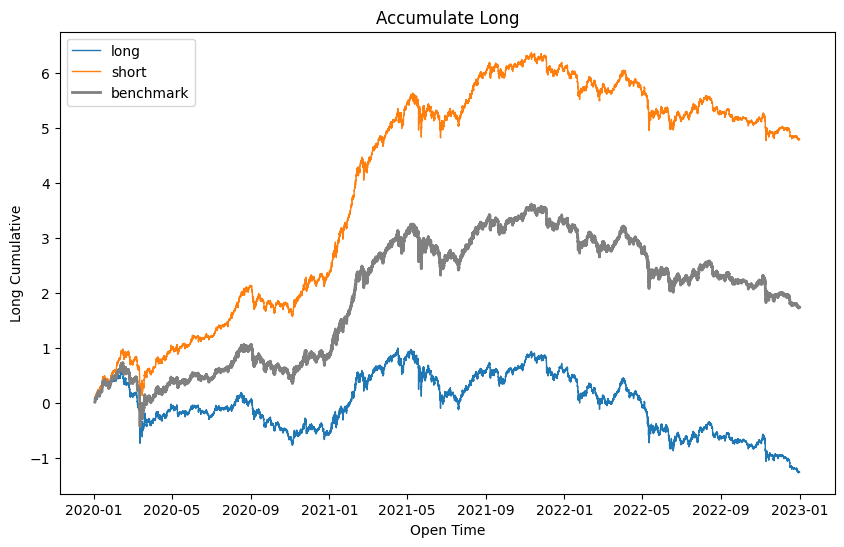

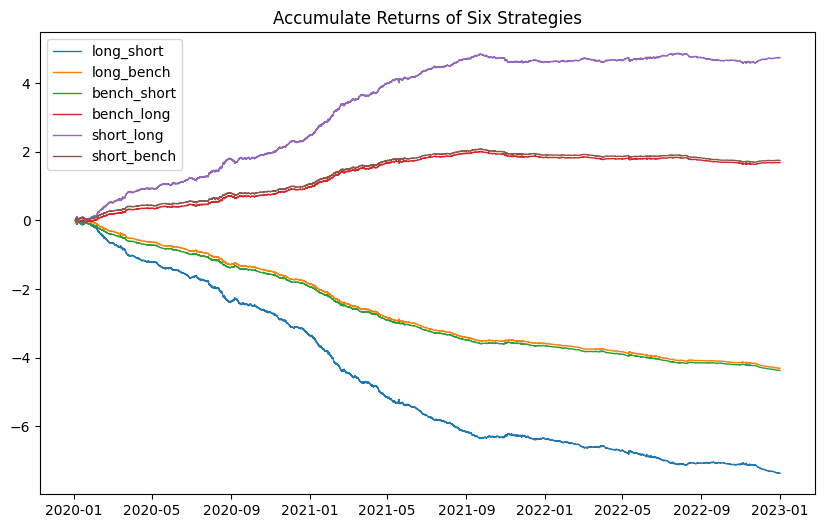

long: 
ann_return = -0.4201  sharpe = -0.3831  maxdd = 1.1344  calmar_ratio = -0.3703  

short: 
ann_return = 1.6001  sharpe = 1.4612  maxdd = 0.5174  calmar_ratio = 3.0924  

bench: 
ann_return = 0.5796  sharpe = 0.5335  maxdd = 0.6728  calmar_ratio = 0.8615  

long_short: 
ann_return = -2.4581  sharpe = -8.7626  maxdd = 7.3255  calmar_ratio = -0.3356  

long_bench: 
ann_return = -1.4377  sharpe = -10.1604  maxdd = 4.2382  calmar_ratio = -0.3392  

bench_long: 
ann_return = 0.5617  sharpe = 3.9695  maxdd = 0.127  calmar_ratio = 4.4222  

short_long: 
ann_return = 1.5821  sharpe = 5.6399  maxdd = 0.1218  calmar_ratio = 12.9882  

short_bench: 
ann_return = 0.5825  sharpe = 4.1415  maxdd = 0.1277  calmar_ratio = 4.5613  

bench_short: 
ann_return = -1.4585  sharpe = -10.3701  maxdd = 4.3665  calmar_ratio = -0.334  



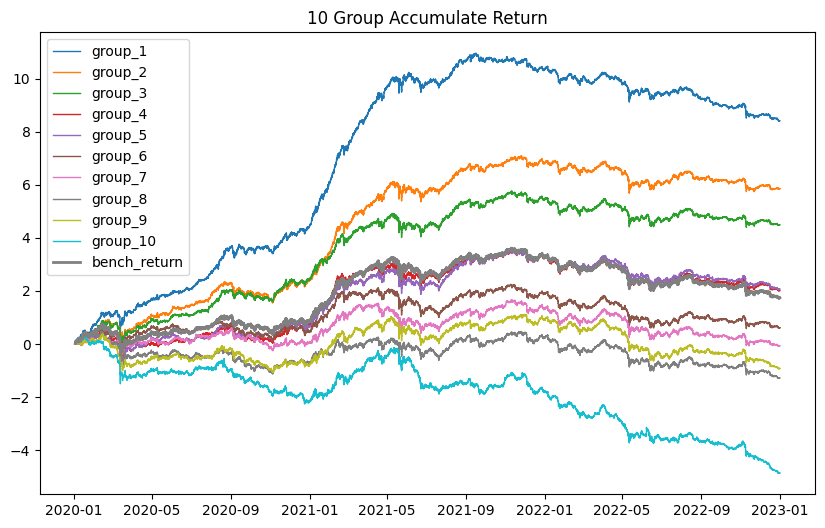

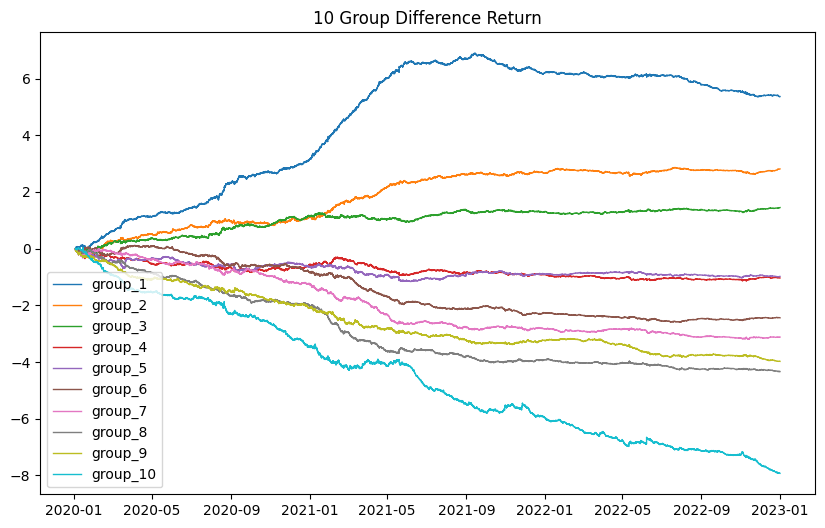

group_1: 
ann_return = 2.8064  sharpe = 2.3941  maxdd = 0.3672  calmar_ratio = 7.6418  

group_2: 
ann_return = 1.9551  sharpe = 1.7221  maxdd = 0.4954  calmar_ratio = 3.9466  

group_3: 
ann_return = 1.5002  sharpe = 1.3208  maxdd = 0.5456  calmar_ratio = 2.7498  

group_4: 
ann_return = 0.6721  sharpe = 0.6007  maxdd = 0.8505  calmar_ratio = 0.7902  

group_5: 
ann_return = 0.69  sharpe = 0.6205  maxdd = 0.9022  calmar_ratio = 0.7648  

group_6: 
ann_return = 0.2032  sharpe = 0.1815  maxdd = 0.6461  calmar_ratio = 0.3146  

group_7: 
ann_return = -0.0239  sharpe = -0.0214  maxdd = 0.7032  calmar_ratio = -0.034  

group_8: 
ann_return = -0.4292  sharpe = -0.3791  maxdd = 1.2034  calmar_ratio = -0.3567  

group_9: 
ann_return = -0.3094  sharpe = -0.2688  maxdd = 1.0609  calmar_ratio = -0.2917  

group_10: 
ann_return = -1.6267  sharpe = -1.3308  maxdd = 3.8203  calmar_ratio = -0.4258  

-----------------------------------------
group_difference_1: 
ann_return = 1.7888  sharpe = 4.3309 

In [28]:
factors = df.select(['open_time', 'symbol', 'money_flow'])
# 对 factors drop NaN
factors = factors.fill_nan(None).drop_nulls()

from factor_analysis.factor_analysis import FactorAnalysis

# 使用示例
analysis = FactorAnalysis(factors, data)
analysis.run_full_analysis()